In [90]:
# Load the necessary libraries
import numpy as np
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# This is for pretty printing
import IPython.display as disp

Constants

In [91]:
# Cell 3: Define physical constants for the system
m1_crank_val, m2_val, m3_val = 1.0, 2.0, 0.5  # Masses (kg) - m1_crank_val is mass of crank arm
L1_val, L2_val = 0.5, 1.5                   # Lengths (m)
I1_crank_val, I2_val = 0.1, 1.5             # Moments of Inertia (kg*m^2) - I1_crank_val is for crank arm about its CoM
F0_val = 50                                 # Force amplitude (N)
k_val = 1                                   # Damping coefficient for crank (Nms/rad)
g_val = 9.81                                # Gravity (m/s^2)

# Flywheel Properties
m_flywheel_val = 5.0 # Mass of the flywheel (kg) - its CoM is at pivot, so its gravity doesn't create torque
r_flywheel_val = 0.5 # Radius of the flywheel (m)
I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2 # Moment of inertia of flywheel about pivot (kg*m^2)

# --- NEW: Gearing Ratio ---
gear_ratio_val = 2.0  # Flywheel rotates 'gear_ratio_val' times for each crank rotation.
                      # e.g., 2.0 means flywheel is faster. 0.5 means flywheel is slower.
# --- END NEW ---

In [92]:
# Cell 4: Define symbolic variables and system matrices
t = sp.symbols('t')
# --- MODIFICATION: Add theta_fw ---
x1, x2, y1, y2, theta1, theta2, x3, y3, theta_fw = dynamicsymbols('x1 x2 y1 y2 theta1 theta2 x3 y3 theta_fw')
q = sp.Matrix([x1, y1, theta1, x2, y2, theta2, x3, y3, theta_fw]) # q now has 9 elements
# --- END MODIFICATION ---
dq = q.diff(t)

x_com_1 = sp.Matrix([x1, y1])
x_com_2 = sp.Matrix([x2, y2])
x_com_3 = sp.Matrix([x3, y3])

R = lambda theta: sp.Matrix([[sp.cos(theta), -sp.sin(theta)], [sp.sin(theta), sp.cos(theta)]])

# --- MODIFICATION: Update Mass Matrix for separate flywheel DOF ---
M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val,    # Body 1 (crank arm)
                m2_val, m2_val, I2_val,                    # Body 2 (conrod)
                m3_val, m3_val,                            # Body 3 (piston trans DoFs)
                I_flywheel_val])                           # DOF for flywheel rotation (theta_fw)
# --- END MODIFICATION ---

W_np = np.linalg.inv(M_np) # M_np is the correct matrix here

# --- MODIFICATION: Update Q for crank arm gravity and add entry for theta_fw ---
Q = sp.Matrix([0,
               -m1_crank_val * g_val,  # Gravity on crank arm CoM
               -k_val * theta1.diff(t), # Damping/load on crankshaft
               0,
               -m2_val * g_val,         # Gravity on conrod
               0,
               0,
               -m3_val * g_val + F0_val * sp.cos(theta1), # Piston forces
               0])                      # No direct external torque on flywheel DOF
# --- END MODIFICATION ---

In [93]:
# Cell 5: Define constraint equations
i_cap = sp.Matrix([1, 0])
j_cap = sp.Matrix([0, 1])

# Crank pivot at origin
constraint_1 = x_com_1 + R(theta1) @ sp.Matrix([-L1_val/2, 0])
C1 = constraint_1.dot(i_cap)
C2 = constraint_1.dot(j_cap)

# Pin joint: crank - conrod
constraint_2 = (x_com_1 + R(theta1) @ sp.Matrix([L1_val/2, 0])) - \
               (x_com_2 + R(theta2) @ sp.Matrix([-L2_val/2, 0]))
C3 = constraint_2.dot(i_cap)
C4 = constraint_2.dot(j_cap)

# Pin joint: conrod - piston
constraint_3 = (x_com_2 + R(theta2) @ sp.Matrix([L2_val/2, 0])) - x_com_3
C5 = constraint_3.dot(i_cap)
C6 = constraint_3.dot(j_cap)

# Piston slides vertically
constraint_4 = x_com_3[0]
C7 = constraint_4

# --- NEW: Gearing Constraint ---
# theta_fw = gear_ratio * theta1 (assuming they start aligned, or phase offset is 0)
# So, theta_fw - gear_ratio_val * theta1 = 0
C_gear = theta_fw - gear_ratio_val * theta1
C8 = C_gear
# --- END NEW ---

# --- MODIFICATION: Add C8 to constraint matrix C ---
C = sp.Matrix([C1, C2, C3, C4, C5, C6, C7, C8]) # C now has 8 constraint equations
# --- END MODIFICATION ---

In [94]:
# Cell 6: Formulate terms for DAE solution and lambdify
J = C.jacobian(q) # J is now 8x9

dC_expr = J @ dq
dJ_times_dq_dt_expr = dC_expr.jacobian(q) @ dq

# --- MODIFICATION: Adjust shape of W_sym ---
W_sym = sp.MatrixSymbol('W_matrix', M_np.shape[0], M_np.shape[1]) # Shape is now 9x9
# --- END MODIFICATION ---

RHS_sym = -dJ_times_dq_dt_expr - J @ W_sym @ Q - 10 * C - 10 * dC_expr # Baumgarte params can be tuned

JWJT_fn = sp.lambdify(args=(q, dq, W_sym), expr=(J @ W_sym @ J.T), modules=['numpy', 'sympy'])
RHS_fn = sp.lambdify(args=(q, dq, W_sym), expr=RHS_sym, modules=['numpy', 'sympy'])

C_fn_num = sp.lambdify(args=(q,), expr=C, modules=['numpy', 'sympy'])
J_fn_num = sp.lambdify(args=(q,), expr=J, modules=['numpy', 'sympy'])
Q_fn_num = sp.lambdify(args=(q, dq), expr=Q, modules=['numpy', 'sympy'])
dC_fn_num = sp.lambdify(args=(q, dq), expr=dC_expr, modules=['numpy', 'sympy'])

In [95]:
# Cell 7: Set up and refine initial conditions
dtheta1_init = 0.5 # rad/s

# --- MODIFICATION: Add initial theta_fw ---
# Assuming theta_fw starts aligned with theta1 according to gear ratio
theta1_init_val = np.pi/2
theta_fw_init_val = gear_ratio_val * theta1_init_val

q_init_guess = np.array([
    0, L1_val/2, theta1_init_val,               # x1, y1, theta1
    0, L1_val + L2_val/2, np.pi/2,              # x2, y2, theta2
    0, L1_val + L2_val,                         # x3, y3
    theta_fw_init_val                           # theta_fw
])
# --- END MODIFICATION ---

C_at_init_pos = C_fn_num(q_init_guess).flatten()
print(f"Initial position constraint violation C(q_init_guess): \n{C_at_init_pos}")
assert np.allclose(C_at_init_pos, 0, atol=1e-6), "Chosen initial positions DO NOT satisfy constraints C=0!"

# --- MODIFICATION: Update velocity_constraint_solver ---
# dq = [dx1, dy1, dtheta1, dx2, dy2, dtheta2, dx3, dy3, dtheta_fw]
# known_dtheta1 is dq[2].
# From dC8/dt = 0: dtheta_fw_dt - gear_ratio * dtheta1_dt = 0
# So, dtheta_fw_dt = gear_ratio * dtheta1_dt. This is dq[8].
# The solver finds the other 7: b_vel = [dx1, dy1, dx2, dy2, dtheta2, dx3, dy3]

def velocity_constraint_solver(b_vel, q_pos, known_dtheta1, known_dtheta_fw):
    # b_vel has 7 elements
    dq_full = np.array([
        b_vel[0], b_vel[1], known_dtheta1,    # dx1, dy1, dtheta1
        b_vel[2], b_vel[3], b_vel[4],    # dx2, dy2, dtheta2
        b_vel[5], b_vel[6],              # dx3, dy3
        known_dtheta_fw                  # dtheta_fw
    ])
    J_num = J_fn_num(q_pos) # J_num is 8x9
    dC_val_all = (J_num @ dq_full).flatten() # Should be 8 zeros
    # We are explicitly setting dtheta_fw_dt based on dtheta1_dt, so dC8/dt should be zero.
    # The solver needs to make the first 7 components of dC_val_all zero.
    return dC_val_all[:7] # Return only the first 7 constraint velocity equations for the 7 unknowns

import scipy.optimize as opt
b_vel_guess = np.zeros(7) # 7 unknowns now

# Enforce the gear ratio for initial velocities
dtheta_fw_init = gear_ratio_val * dtheta1_init

solution = opt.root(velocity_constraint_solver, b_vel_guess,
                    args=(q_init_guess, dtheta1_init, dtheta_fw_init),
                    method='hybr', options={'xtol': 1e-8}) # Added xtol for robustness

if not solution.success:
    print(f"Warning: Initial velocity optimization might not have converged. Message: {solution.message}")

b_vel_sol = solution.x
dq_init_consistent = np.array([
    b_vel_sol[0], b_vel_sol[1], dtheta1_init,
    b_vel_sol[2], b_vel_sol[3], b_vel_sol[4],
    b_vel_sol[5], b_vel_sol[6],
    dtheta_fw_init # dq[8] is dtheta_fw
])
# --- END MODIFICATION ---

# Verify all constraints
J_num_init = J_fn_num(q_init_guess)
dC_at_init_vel_all = (J_num_init @ dq_init_consistent).flatten()
print(f"Full initial velocity constraint violation dC(q_init, dq_consistent): \n{dC_at_init_vel_all}")
assert np.allclose(dC_at_init_vel_all, 0, atol=1e-6), "Solved initial velocities DO NOT satisfy all dC=0!"

x0 = np.concatenate((q_init_guess, dq_init_consistent))
print("\nConsistent initial state vector x0 (9 positions, 9 velocities):")
print(x0)

Initial position constraint violation C(q_init_guess): 
[-1.5308085e-17  0.0000000e+00  6.1232340e-17  0.0000000e+00
  4.5924255e-17  0.0000000e+00  0.0000000e+00  0.0000000e+00]
Full initial velocity constraint violation dC(q_init, dq_consistent): 
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.43492963e-42 -1.89911355e-65  0.00000000e+00]

Consistent initial state vector x0 (9 positions, 9 velocities):
[ 0.00000000e+00  2.50000000e-01  1.57079633e+00  0.00000000e+00
  1.25000000e+00  1.57079633e+00  0.00000000e+00  2.00000000e+00
  3.14159265e+00 -1.25000000e-01  7.65404249e-18  5.00000000e-01
 -1.25000000e-01  7.65404249e-18 -1.66666667e-01 -1.89911355e-65
  1.43492963e-42  1.00000000e+00]


Calculate initial conditions for the system

In [96]:
# import scipy.optimize as opt

# x, _ = np.split(x0, 2)
# def optimiser(b):
#     dx1, dy1, dx2, dy2, dtheta2, dx3, dy3 = b
#     dq = np.array([dx1, dy1, dtheta1, dx2, dy2, dtheta2, dx3, dy3])
#     val = dC_fn(x, dq).flatten()
#     return val

# initial_guess = np.array([0, 0, 0, 0, 0, 0, 0])
# result = opt.root(optimiser, initial_guess)
# print(result)

# b = result.x
# dx = np.array([b[0], b[1], dtheta1, b[2], b[3], b[4], b[5], b[6]])

# C_val = C_fn(x, dx)
# dC_val = dC_fn(x, dx)

# print(f'Position constraint: {C_val}')
# print(f'Velocity constraint: {dC_val}')
# assert np.allclose(C_val, 0), "Initial position constraint violated"
# assert np.allclose(dC_val, 0), "Initial velocity constraint violated"
# x0 = np.concatenate((x, dx))
# x0

In [97]:
# Cell 8: Define the function for the DAE solver (name is already appropriate)
def piston_engine_flywheel(t, state):
    q_num, dq_num = np.split(state, 2)

    JWJT_val = JWJT_fn(q_num, dq_num, W_np)
    RHS_val = RHS_fn(q_num, dq_num, W_np)

    try:
        lam = np.linalg.solve(JWJT_val, RHS_val)
    except np.linalg.LinAlgError:
        print(f"Singular matrix encountered at t={t}. Using pseudo-inverse.")
        lam = np.linalg.pinv(JWJT_val) @ RHS_val

    J_val_num = J_fn_num(q_num)
    Qhat = J_val_num.T @ lam

    Q_val_num = Q_fn_num(q_num, dq_num)
    ddq = W_np @ (Q_val_num + Qhat)
    ddq = ddq.flatten()

    return np.concatenate((dq_num, ddq))

# Test run
initial_derivatives = piston_engine_flywheel(0, x0)
print("\nInitial derivatives (dq, ddq) from test run:")
print(initial_derivatives)


Initial derivatives (dq, ddq) from test run:
[-1.25000000e-01  7.65404249e-18  5.00000000e-01 -1.25000000e-01
  7.65404249e-18 -1.66666667e-01 -1.89911355e-65  1.43492963e-42
  1.00000000e+00  4.23131171e-02 -6.25000000e-02 -1.69252468e-01
  4.23131171e-02 -1.45833333e-01  5.64174894e-02  0.00000000e+00
 -1.66666667e-01 -3.38504937e-01]


In [98]:
# Cell 9: Run the numerical simulation
t_start = 0
t_end = 10 # Reduced time for quicker test, original was 30
num_points = 500 # Original was 500

t_span = (t_start, t_end)
t_eval = np.linspace(*t_span, num_points)

print("\nStarting numerical integration...")
sol = solve_ivp(piston_engine_flywheel, t_span, x0,
                atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval)
print("Integration finished.")
print(f"Solver status: {sol.message}")
if not sol.success:
    print("Warning: Solver did not terminate successfully.")

# Explanation:
# t_start, t_end, num_points: Parameters for the simulation time.
# t_span: Tuple defining the start and end time of the simulation.
# t_eval: Array of time points where the solution should be stored.
# solve_ivp: Solves the system of DAEs.
#    - piston_engine_flywheel: The function defining the system dynamics.
#    - t_span: Integration interval.
#    - x0: Consistent initial state.
#    - atol, rtol: Absolute and relative error tolerances for the solver.
#    - method='BDF': Uses the Backward Differentiation Formula, good for stiff DAEs.
#    - t_eval: Times at which to store the solution.
# sol: The solution object containing time points (sol.t) and state vectors (sol.y).
# Print statements provide feedback on the integration process.


Starting numerical integration...
Integration finished.
Solver status: The solver successfully reached the end of the integration interval.


Animation

In [99]:
# Class for drawing the box
class Box:
    def __init__(self, width, height, color='b'):
        self.width = width
        self.height = height
        self.color = color
        self.offset = -np.array([width/2, height/2])

    def first_draw(self, ax):
        corner = np.array([0, 0])
        self.patch = plt.Rectangle(corner, 0, 0, angle=0, 
                        rotation_point='center', color=self.color, animated=True)
        ax.add_patch(self.patch)
        self.ax = ax
        return self.patch
    
    def set_data(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta

    def update(self, i):
        x, y, theta = self.x[i], self.y[i], self.theta[i]
        theta = np.rad2deg(theta)

        # The rectangle is drawn from the left bottom corner
        # So, we need to calculate the corner position
        corner = np.array([x, y]) + self.offset

        # Update the values for the rectangle
        self.patch.set_width(self.width)
        self.patch.set_height(self.height)
        self.patch.set_xy(corner)
        self.patch.set_angle(theta)
        return self.patch
    
# --- MODIFICATION: Corrected Circle class for the flywheel WITH a rotating line ---
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

class FlywheelVisual:
    def __init__(self, radius, color='dimgray', line_color='black', line_angle_offset_rad=np.pi/2):
        self.radius = radius
        self.color = color
        self.line_color = line_color
        self.line_angle_offset_rad = line_angle_offset_rad
        self.patch = None
        self.line = None

    def first_draw(self, ax):
        self.patch = Circle((0,0), self.radius, fc=self.color, animated=True, zorder=1)
        ax.add_patch(self.patch)
        self.line = Line2D([0, 0], [0, 0], color=self.line_color, lw=2, animated=True, zorder=2)
        ax.add_line(self.line)
        return [self.patch, self.line]

    # --- MODIFICATION: set_data now takes theta_flywheel_array ---
    def set_data(self, center_x_array, center_y_array, theta_flywheel_array):
        self.center_x_array = center_x_array
        self.center_y_array = center_y_array
        self.theta_flywheel_array = theta_flywheel_array # This is the flywheel's own angle
    # --- END MODIFICATION ---

    def update(self, i):
        cx = self.center_x_array[i]
        cy = self.center_y_array[i]
        self.patch.center = (cx, cy)
        
        # --- MODIFICATION: Line rotates with theta_flywheel, offset is for visual distinction ---
        th_flywheel_effective = self.theta_flywheel_array[i] + self.line_angle_offset_rad
        # --- END MODIFICATION ---
        
        line_start_x = cx
        line_start_y = cy
        line_end_x = cx + self.radius * np.cos(th_flywheel_effective)
        line_end_y = cy + self.radius * np.sin(th_flywheel_effective)
        
        self.line.set_data([line_start_x, line_end_x], [line_start_y, line_end_y])
        
        return [self.patch, self.line]

In [100]:
# Cell 12: Create and display the animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig_anim, ax_anim = plt.subplots(figsize=(6,8))
plt.close(fig_anim)

ax_anim.set_ylim(- (L1_val + L2_val + r_flywheel_val + 0.2), (L1_val + L2_val + r_flywheel_val + 0.2) )
ax_anim.set_xlim(- (L1_val + r_flywheel_val + 0.2), (L1_val + r_flywheel_val + 0.2) )
ax_anim.set_aspect('equal')
ax_anim.grid(True)

# Get the position and angle data from the solution
# sol.y now contains [x1,y1,th1, x2,y2,th2, x3,y3, th_fw]
x1_sol, y1_sol, theta1_sol = sol.y[0,:], sol.y[1,:], sol.y[2,:]
x2_sol, y2_sol, theta2_sol = sol.y[3,:], sol.y[4,:], sol.y[5,:]
x3_sol, y3_sol             = sol.y[6,:], sol.y[7,:]
theta_fw_sol               = sol.y[8,:] # --- NEW: Extract flywheel angle ---
theta3_sol = np.zeros_like(x3_sol)

crank_visual = Box(L1_val, 0.05, color='blue')
conrod_visual = Box(L2_val, 0.05, color='red')
piston_visual = Box(0.2, 0.4, color='green')

# --- MODIFICATION: Flywheel line angle offset (e.g., 0 or np.pi/2 for visibility if gear_ratio=1) ---
# If gear_ratio is not 1, offset might not be needed as it will naturally differ from crank.
# Let's set offset to 0 for now, so line directly indicates theta_fw.
flywheel_visual_obj = FlywheelVisual(r_flywheel_val, color='dimgray', line_color='black', line_angle_offset_rad=0)
# --- END MODIFICATION ---

crank_visual.set_data(x1_sol, y1_sol, theta1_sol)
conrod_visual.set_data(x2_sol, y2_sol, theta2_sol)
piston_visual.set_data(x3_sol, y3_sol, theta3_sol)

flywheel_center_x_data = np.zeros_like(theta1_sol)
flywheel_center_y_data = np.zeros_like(theta1_sol)
# --- MODIFICATION: Pass theta_fw_sol to flywheel visual ---
flywheel_visual_obj.set_data(flywheel_center_x_data, flywheel_center_y_data, theta_fw_sol)
# --- END MODIFICATION ---

artists_to_animate = [flywheel_visual_obj, piston_visual, conrod_visual, crank_visual]

# init_animation and animate_frame functions remain the same as the previous corrected version.
def init_animation():
    ax_anim.set_title("t=0.00 sec", fontsize=15)
    all_patches_flat = []
    for artist_obj in artists_to_animate:
        patches_from_obj = artist_obj.first_draw(ax_anim)
        if isinstance(patches_from_obj, list):
            all_patches_flat.extend(patches_from_obj)
        else:
            all_patches_flat.append(patches_from_obj)
    return all_patches_flat

def animate_frame(i):
    ax_anim.set_title(f"t={sol.t[i]:.2f} sec", fontsize=15)
    updated_patches_flat = []
    for artist_obj in artists_to_animate:
        patches_from_obj = artist_obj.update(i)
        if isinstance(patches_from_obj, list):
            updated_patches_flat.extend(patches_from_obj)
        else:
            updated_patches_flat.append(patches_from_obj)
    return updated_patches_flat

sim_dt = sol.t[1] - sol.t[0] if len(sol.t) > 1 else 0.04
animation_interval_ms = 1000 * sim_dt

anim_piston = FuncAnimation(fig_anim, animate_frame, frames=len(sol.t),
                            init_func=init_animation, blit=False, interval=max(20, animation_interval_ms))

html_video = HTML(anim_piston.to_html5_video())
disp.display(html_video)

In [101]:
# Cell 13: Helper functions for parameter variation and simulation setup
# Store original constants from Cell 3 (and any other relevant ones)
original_constants = {
    "m1_crank_val": m1_crank_val, "m2_val": m2_val, "m3_val": m3_val,
    "L1_val": L1_val, "L2_val": L2_val,
    "I1_crank_val": I1_crank_val, "I2_val": I2_val,
    "F0_val": F0_val, "k_val": k_val, "g_val": g_val,
    "m_flywheel_val": m_flywheel_val, "r_flywheel_val": r_flywheel_val,
    "gear_ratio_val": gear_ratio_val # Crucial for symbolic changes
}

current_constants_store = {} # To backup global variables during looped simulations

def update_and_set_globals(param_name_to_change, param_value):
    """
    Updates global Python variables based on the parameter being varied.
    It uses 'original_constants' as a base and modifies the specific parameter.
    It also recalculates derived constants like I_flywheel_val, M_np, W_np.
    Returns the 'current' gear_ratio_val, which is needed by setup_symbolic_system and get_initial_conditions_param.
    """
    global m1_crank_val, m2_val, m3_val, L1_val, L2_val, I1_crank_val, I2_val
    global F0_val, k_val, g_val, m_flywheel_val, r_flywheel_val, I_flywheel_val
    global gear_ratio_val # This is a Python global that Sympy expressions might use
    global M_np, W_np, q_sym_size # These are numpy arrays/globals used by solver

    # Store original global values if not already done for this "session" of running the loop
    if not current_constants_store:
        current_constants_store["m1_crank_val"] = original_constants["m1_crank_val"]
        current_constants_store["m2_val"] = original_constants["m2_val"]
        current_constants_store["m3_val"] = original_constants["m3_val"]
        current_constants_store["L1_val"] = original_constants["L1_val"]
        current_constants_store["L2_val"] = original_constants["L2_val"]
        current_constants_store["I1_crank_val"] = original_constants["I1_crank_val"]
        current_constants_store["I2_val"] = original_constants["I2_val"]
        current_constants_store["F0_val"] = original_constants["F0_val"]
        current_constants_store["k_val"] = original_constants["k_val"]
        current_constants_store["g_val"] = original_constants["g_val"]
        current_constants_store["m_flywheel_val"] = original_constants["m_flywheel_val"]
        current_constants_store["r_flywheel_val"] = original_constants["r_flywheel_val"]
        current_constants_store["gear_ratio_val"] = original_constants["gear_ratio_val"]

    # Create a working copy from original_constants, then update the specific param
    temp_constants = original_constants.copy()
    temp_constants[param_name_to_change] = param_value
    
    # Update global Python variables from temp_constants
    # These globals will be used by setup_symbolic_system when defining SymPy expressions
    m1_crank_val = temp_constants["m1_crank_val"]
    m2_val = temp_constants["m2_val"]
    m3_val = temp_constants["m3_val"]
    L1_val = temp_constants["L1_val"]
    L2_val = temp_constants["L2_val"]
    I1_crank_val = temp_constants["I1_crank_val"]
    I2_val = temp_constants["I2_val"]
    F0_val = temp_constants["F0_val"]
    k_val = temp_constants["k_val"]
    g_val = temp_constants["g_val"]
    m_flywheel_val = temp_constants["m_flywheel_val"]
    r_flywheel_val = temp_constants["r_flywheel_val"]
    gear_ratio_val = temp_constants["gear_ratio_val"]

    # Update derived constants that affect M_np, W_np
    I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2
    
    M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val,
                    m2_val, m2_val, I2_val,
                    m3_val, m3_val,
                    I_flywheel_val])
    if M_np.shape[0] == 0: # Should not happen if constants are numbers
        raise ValueError("M_np is empty. Check constant definitions.")
    W_np = np.linalg.inv(M_np)
    q_sym_size = M_np.shape[0] # Number of generalized coordinates
    
    return temp_constants["gear_ratio_val"] # Return the gear_ratio_val used for this run

def restore_globals_from_original():
    """Restores global Python variables from the 'original_constants' dictionary."""
    global m1_crank_val, m2_val, m3_val, L1_val, L2_val, I1_crank_val, I2_val
    global F0_val, k_val, g_val, m_flywheel_val, r_flywheel_val, I_flywheel_val
    global gear_ratio_val, M_np, W_np
    
    m1_crank_val = original_constants["m1_crank_val"]
    m2_val = original_constants["m2_val"]
    m3_val = original_constants["m3_val"]
    L1_val = original_constants["L1_val"]
    L2_val = original_constants["L2_val"]
    I1_crank_val = original_constants["I1_crank_val"]
    I2_val = original_constants["I2_val"]
    F0_val = original_constants["F0_val"]
    k_val = original_constants["k_val"]
    g_val = original_constants["g_val"]
    m_flywheel_val = original_constants["m_flywheel_val"]
    r_flywheel_val = original_constants["r_flywheel_val"]
    gear_ratio_val = original_constants["gear_ratio_val"]
        
    I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2
    M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val, m2_val, m2_val, I2_val, m3_val, m3_val, I_flywheel_val])
    W_np = np.linalg.inv(M_np)
    
    current_constants_store.clear() # Clear the backup store

# Global placeholder for current lambdified functions, to be used by the solver
current_lambdified_fns = {}

def setup_symbolic_system_param(current_gear_ratio_val_sym):
    """
    Re-defines symbolic expressions and re-lambdifies them.
    Uses current global Python variables for physical constants (e.g., L1_val, m1_crank_val).
    'current_gear_ratio_val_sym' is the specific value for gear_ratio for this setup.
    """
    # Make sure SymPy dynamicsymbols are available (usually from Cell 1)
    # from sympy.physics.mechanics import dynamicsymbols 
    
    t_loc = sp.symbols('t')
    # Using _loc to avoid collision if these are already global SymPy symbols
    x1_loc, y1_loc, theta1_loc, x2_loc, y2_loc, theta2_loc, x3_loc, y3_loc, theta_fw_loc = dynamicsymbols('x1 y1 theta1 x2 y2 theta2 x3 y3 theta_fw')
    q_loc = sp.Matrix([x1_loc, y1_loc, theta1_loc, x2_loc, y2_loc, theta2_loc, x3_loc, y3_loc, theta_fw_loc])
    dq_loc = q_loc.diff(t_loc)

    # Q matrix (Cell 4, uses current global Python variables for constants)
    Q_expr_loc = sp.Matrix([0,
                       -m1_crank_val * g_val,
                       -k_val * theta1_loc.diff(t_loc),
                       0,
                       -m2_val * g_val,
                       0,
                       0,
                       -m3_val * g_val + F0_val * sp.cos(theta1_loc),
                       0])

    # Constraints (Cell 5, uses current global Python variables for L1_val, L2_val etc.)
    x_com_1_loc = sp.Matrix([x1_loc, y1_loc])
    x_com_2_loc = sp.Matrix([x2_loc, y2_loc])
    x_com_3_loc = sp.Matrix([x3_loc, y3_loc])
    _R_loc = lambda theta_arg: sp.Matrix([[sp.cos(theta_arg), -sp.sin(theta_arg)], [sp.sin(theta_arg), sp.cos(theta_arg)]])
    i_cap_loc = sp.Matrix([1, 0])
    j_cap_loc = sp.Matrix([0, 1])

    constraint_1_loc = x_com_1_loc + _R_loc(theta1_loc) @ sp.Matrix([-L1_val/2, 0])
    C1_loc = constraint_1_loc.dot(i_cap_loc)
    C2_loc = constraint_1_loc.dot(j_cap_loc)
    constraint_2_loc = (x_com_1_loc + _R_loc(theta1_loc) @ sp.Matrix([L1_val/2, 0])) - \
                       (x_com_2_loc + _R_loc(theta2_loc) @ sp.Matrix([-L2_val/2, 0]))
    C3_loc = constraint_2_loc.dot(i_cap_loc)
    C4_loc = constraint_2_loc.dot(j_cap_loc)
    constraint_3_loc = (x_com_2_loc + _R_loc(theta2_loc) @ sp.Matrix([L2_val/2, 0])) - x_com_3_loc
    C5_loc = constraint_3_loc.dot(i_cap_loc)
    C6_loc = constraint_3_loc.dot(j_cap_loc)
    constraint_4_loc = x_com_3_loc[0]
    C7_loc = constraint_4_loc
    # Use the passed current_gear_ratio_val_sym for this specific setup
    C_gear_loc = theta_fw_loc - current_gear_ratio_val_sym * theta1_loc 
    C8_loc = C_gear_loc
    C_expr_loc = sp.Matrix([C1_loc, C2_loc, C3_loc, C4_loc, C5_loc, C6_loc, C7_loc, C8_loc])

    # DAE terms (Cell 6)
    J_expr_loc = C_expr_loc.jacobian(q_loc)
    dC_expr_loc_dt = J_expr_loc @ dq_loc # This is dC/dt, not dC_expr
    # dJ_times_dq_dt_expr_loc = dC_expr_loc_dt.jacobian(q_loc) @ dq_loc # This is (d/dq (J dq)) dq
    # A more standard way for dJ/dt * dq :
    dJdt_expr_loc = J_expr_loc.diff(t_loc) # This works if symbols in J are dynamic symbols
    dJ_times_dq_dt_expr_loc = dJdt_expr_loc @ dq_loc


    # W_sym uses the global M_np's shape, which should be up-to-date via update_and_set_globals
    W_sym_loc = sp.MatrixSymbol('W_matrix', M_np.shape[0], M_np.shape[1])
    # Baumgarte stabilization terms alpha=10, beta=10 (can be tuned)
    alpha_baum = 10 
    beta_baum = 10
    RHS_sym_expr_loc = -dJ_times_dq_dt_expr_loc - J_expr_loc @ W_sym_loc @ Q_expr_loc - beta_baum * dC_expr_loc_dt - alpha_baum * C_expr_loc


    lambdified_fns_dict = {
        "JWJT_fn": sp.lambdify(args=(q_loc, dq_loc, W_sym_loc), expr=(J_expr_loc @ W_sym_loc @ J_expr_loc.T), modules=['numpy', 'sympy']),
        "RHS_fn": sp.lambdify(args=(t_loc, q_loc, dq_loc, W_sym_loc), expr=RHS_sym_expr_loc, modules=['numpy', 'sympy']), # Added t_loc
        "C_fn_num": sp.lambdify(args=(q_loc,), expr=C_expr_loc, modules=['numpy', 'sympy']),
        "J_fn_num": sp.lambdify(args=(q_loc,), expr=J_expr_loc, modules=['numpy', 'sympy']),
        "Q_fn_num": sp.lambdify(args=(t_loc, q_loc, dq_loc), expr=Q_expr_loc, modules=['numpy', 'sympy']), # Added t_loc
        "dC_dt_fn_num": sp.lambdify(args=(t_loc, q_loc, dq_loc), expr=dC_expr_loc_dt, modules=['numpy', 'sympy']), # Added t_loc
        "num_gen_coords": q_loc.shape[0] # Store the number of generalized coordinates
    }
    return lambdified_fns_dict

def get_initial_conditions_param(fns_dict, current_gear_ratio_val_ic):
    """
    Calculates consistent initial conditions using the provided lambdified functions
    and the specific gear_ratio_val for this run.
    """
    _J_fn_num_ic = fns_dict["J_fn_num"]
    _C_fn_num_ic = fns_dict["C_fn_num"]
    
    dtheta1_init_ic = 0.5 
    theta1_init_val_ic = np.pi/2 
    # Use the gear_ratio_val specific to this run for initial conditions
    theta_fw_init_val_ic = current_gear_ratio_val_ic * theta1_init_val_ic

    # L1_val, L2_val are current global Python variables
    q_init_guess_ic = np.array([
        0, L1_val/2, theta1_init_val_ic,
        0, L1_val + L2_val/2, np.pi/2,
        0, L1_val + L2_val,
        theta_fw_init_val_ic
    ])

    # Refine initial positions to satisfy C(q)=0 using Newton-Raphson
    for _ in range(10): # Max 10 iterations for position refinement
        C_at_init_pos_val = _C_fn_num_ic(q_init_guess_ic).flatten()
        if np.allclose(C_at_init_pos_val, 0, atol=1e-7):
            break
        J_at_init_pos_val = _J_fn_num_ic(q_init_guess_ic)
        try:
            # Use pseudo-inverse for potentially non-square or singular J during refinement
            delta_q = np.linalg.lstsq(J_at_init_pos_val, -C_at_init_pos_val, rcond=None)[0]
        except np.linalg.LinAlgError:
            print("LinAlgError during position refinement, trying pseudo-inverse more directly.")
            delta_q = np.linalg.pinv(J_at_init_pos_val) @ -C_at_init_pos_val

        q_init_guess_ic = q_init_guess_ic + delta_q.flatten()
    else: # If loop finished without break
        C_final_check = _C_fn_num_ic(q_init_guess_ic).flatten()
        if not np.allclose(C_final_check, 0, atol=1e-5): # Relax tolerance slightly after iterations
             print(f"Warning: Initial position refinement might not have fully converged. Violation: {C_final_check}")
        # assert np.allclose(C_final_check, 0, atol=1e-5), f"Initial positions DO NOT satisfy C=0 after refinement! Violation: {C_final_check}"


    def velocity_constraint_solver_ic(b_vel, q_pos, known_dtheta1, known_dtheta_fw):
        dq_full = np.array([
            b_vel[0], b_vel[1], known_dtheta1,
            b_vel[2], b_vel[3], b_vel[4],
            b_vel[5], b_vel[6],
            known_dtheta_fw
        ])
        J_num_val = _J_fn_num_ic(q_pos)
        dC_val_all = (J_num_val @ dq_full).flatten()
        return dC_val_all[:7] # Solve for the first 7 dC/dt = 0

    b_vel_guess_ic = np.zeros(7)
    dtheta_fw_init_ic = current_gear_ratio_val_ic * dtheta1_init_ic
    
    # scipy.optimize needs to be imported, assume it's available from original notebook (Cell 7)
    # import scipy.optimize as opt 
    solution_ic = opt.root(velocity_constraint_solver_ic, b_vel_guess_ic,
                        args=(q_init_guess_ic, dtheta1_init_ic, dtheta_fw_init_ic),
                        method='hybr', options={'xtol': 1e-9, 'maxfev': 2000*(7+1)})


    if not solution_ic.success:
        print(f"Warning: Initial velocity optimization might not have converged for gear_ratio={current_gear_ratio_val_ic}. Msg: {solution_ic.message}")

    b_vel_sol_ic = solution_ic.x
    dq_init_consistent_ic = np.array([
        b_vel_sol_ic[0], b_vel_sol_ic[1], dtheta1_init_ic,
        b_vel_sol_ic[2], b_vel_sol_ic[3], b_vel_sol_ic[4],
        b_vel_sol_ic[5], b_vel_sol_ic[6],
        dtheta_fw_init_ic
    ])

    J_num_init_val = _J_fn_num_ic(q_init_guess_ic)
    dC_at_init_vel_all_val = (J_num_init_val @ dq_init_consistent_ic).flatten()
    if not np.allclose(dC_at_init_vel_all_val, 0, atol=1e-5):
        print(f"Warning: Solved IC velocities DO NOT satisfy dC=0! Violation for gr={current_gear_ratio_val_ic}: {dC_at_init_vel_all_val}")
    # assert np.allclose(dC_at_init_vel_all_val, 0, atol=1e-5), f"Solved IC velocities DO NOT satisfy dC=0! Violation for gr={current_gear_ratio_val_ic}: {dC_at_init_vel_all_val}"
    
    return np.concatenate((q_init_guess_ic, dq_init_consistent_ic))

def piston_engine_flywheel_param_solver(t_param, state_param):
    """
    Solver function for solve_ivp, uses current_lambdified_fns and global W_np.
    """
    _JWJT_fn_param = current_lambdified_fns["JWJT_fn"]
    _RHS_fn_param = current_lambdified_fns["RHS_fn"]
    _J_fn_num_param = current_lambdified_fns["J_fn_num"]
    _Q_fn_num_param = current_lambdified_fns["Q_fn_num"]
    
    num_coords = current_lambdified_fns["num_gen_coords"]
    q_num_param, dq_num_param = np.split(state_param, 2)

    # W_np is global and updated by update_and_set_globals
    JWJT_val_param = _JWJT_fn_param(q_num_param, dq_num_param, W_np) 
    RHS_val_param = _RHS_fn_param(t_param, q_num_param, dq_num_param, W_np).flatten() # Ensure RHS is 1D

    try:
        lam_param = np.linalg.solve(JWJT_val_param, RHS_val_param)
    except np.linalg.LinAlgError:
        # print(f"Singular matrix at t={t_param:.3f}. Using pseudo-inverse.")
        lam_param = np.linalg.pinv(JWJT_val_param) @ RHS_val_param

    J_val_num_param = _J_fn_num_param(q_num_param)
    Qhat_param = J_val_num_param.T @ lam_param.reshape(-1,1) # Ensure lam_param is column vector
    
    Q_val_num_param = _Q_fn_num_param(t_param, q_num_param, dq_num_param)
    ddq_param = W_np @ (Q_val_num_param + Qhat_param) # Qhat_param is (9,1), Q_val_num_param is (9,1)
    ddq_param = ddq_param.flatten()

    return np.concatenate((dq_num_param, ddq_param))

In [102]:
# Cell 14: Main simulation loop for parameter variation (MODIFIED for Engine Torque & Power)

# --- CHOOSE PARAMETER TO VARY ---
# parameter_to_vary = "gear_ratio_val"
# values_to_test = [0.5, 1.0, 2.0]

# parameter_to_vary = "m_flywheel_val"
# values_to_test = [25.0, 50.0, 75.0]

parameter_to_vary = "r_flywheel_val"
values_to_test = [0.15, 0.25, 0.35, 0.5, 1]

# parameter_to_vary = "L1_val"
# values_to_test = [0.4, 0.5, 0.6]

# parameter_to_vary = "m1_crank_val" # Note: I1_crank_val might also need to scale with mass for realism
# values_to_test = [0.8, 1.0, 1.2]
# ----------------------------------

all_simulation_results = []

# Initialize or clear backup store if necessary before the loop starts
if 'current_constants_store' not in globals():
    current_constants_store = {}
else:
    current_constants_store.clear()

# Backup original state before starting loop (only if not already backed up)
# Assumes 'original_constants' dictionary exists and helper functions are defined
if not current_constants_store and 'original_constants' in globals() and 'update_and_set_globals' in globals() and 'restore_globals_from_original' in globals():
    # Call update_and_set_globals with any parameter just to populate the backup
    # The value doesn't matter here as it will be restored immediately.
    _ = update_and_set_globals(parameter_to_vary, values_to_test[0])
    # Restore immediately so the loop starts from the original state
    restore_globals_from_original()
elif 'original_constants' not in globals() or 'update_and_set_globals' not in globals() or 'restore_globals_from_original' not in globals():
     print("Warning: Cannot backup/restore global constants. Ensure 'original_constants' and helper functions are defined.")


print(f"Starting flywheel simulations, varying: {parameter_to_vary}")
for val_idx, current_val_to_test in enumerate(values_to_test):
    print(f"  Run {val_idx+1}/{len(values_to_test)}: {parameter_to_vary} = {current_val_to_test}")

    # Update global Python variables and symbolic system for this specific run
    # Assumes helper functions setup_symbolic_system_param and get_initial_conditions_param exist
    effective_gear_ratio_for_run = update_and_set_globals(parameter_to_vary, current_val_to_test)
    current_lambdified_fns = setup_symbolic_system_param(effective_gear_ratio_for_run)
    x0_run = get_initial_conditions_param(current_lambdified_fns, effective_gear_ratio_for_run)

    # Simulation time settings for this run
    t_start_sim, t_end_sim = 0, 40
    num_points_sim = 10000

    t_span_sim = (t_start_sim, t_end_sim)
    t_eval_sim = np.linspace(*t_span_sim, num_points_sim)

    # Run the simulation for the current parameter value
    # Assumes solver function piston_engine_flywheel_param_solver exists
    sol_run = solve_ivp(piston_engine_flywheel_param_solver, t_span_sim, x0_run,
                        atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval_sim)

    # --- Store results or handle failure ---
    if not sol_run.success:
        print(f"    Warning: Solver FAILED for {parameter_to_vary}={current_val_to_test}. Message: {sol_run.message}")
        # Store NaN results to keep alignment in all_simulation_results
        all_simulation_results.append({
            "t": t_eval_sim, "y_piston": np.full_like(t_eval_sim, np.nan),
            "v_piston": np.full_like(t_eval_sim, np.nan), "a_piston": np.full_like(t_eval_sim, np.nan),
            "theta1_crank": np.full_like(t_eval_sim, np.nan),
            "dtheta1_crank": np.full_like(t_eval_sim, np.nan),
            "ddtheta1_crank": np.full_like(t_eval_sim, np.nan),
            "T_engine_crank": np.full_like(t_eval_sim, np.nan),
            "P_engine_crank": np.full_like(t_eval_sim, np.nan),
            "flywheel_torque_output": np.full_like(t_eval_sim, np.nan),
            "param_varied": parameter_to_vary, "param_value": current_val_to_test,
            "success": False, "system_type": "flywheel" # Added system_type
        })
        continue # Skip post-processing for failed runs

    # --- Post-process successful run ---
    num_gen_coords_run = current_lambdified_fns["num_gen_coords"]

    # Basic Kinematics from solution state vector
    y_piston_run = sol_run.y[7,:]
    theta1_crank_run = sol_run.y[2,:]
    dtheta1_crank_run = sol_run.y[num_gen_coords_run + 2,:] # dq[2]

    # Re-calculate accelerations and constraint forces (lambda) for analysis
    a_piston_run = np.zeros_like(sol_run.t)
    ddtheta1_crank_accel_run = np.zeros_like(sol_run.t) # ddq[2]
    lam7_values_run = np.zeros_like(sol_run.t) # Lambda corresponding to gear constraint C8

    # Access lambdified functions needed for post-processing from the dictionary
    _JWJT_fn_param_loop = current_lambdified_fns["JWJT_fn"]
    _RHS_fn_param_loop = current_lambdified_fns["RHS_fn"]
    _J_fn_num_param_loop = current_lambdified_fns["J_fn_num"]
    _Q_fn_num_param_loop = current_lambdified_fns["Q_fn_num"]

    # Ensure W_np is the currently correct global numpy matrix
    # W_np should have been updated within update_and_set_globals

    for i_step in range(len(sol_run.t)):
        current_t_step = sol_run.t[i_step]
        current_state_step = sol_run.y[:,i_step]
        q_num_step, dq_num_step = np.split(current_state_step, 2)

        # Calculate lambda at this step
        JWJT_val_step = _JWJT_fn_param_loop(q_num_step, dq_num_step, W_np) # Pass current W_np
        RHS_val_step = _RHS_fn_param_loop(current_t_step, q_num_step, dq_num_step, W_np).flatten() # Pass current W_np

        try:
            # JWJT_val_step should be 8x8, RHS_val_step should be 8x1
            lam_step = np.linalg.solve(JWJT_val_step, RHS_val_step)
        except np.linalg.LinAlgError:
            # print(f"LinAlgError at t={current_t_step}, using pseudo-inverse for lambda.")
            lam_step = np.linalg.pinv(JWJT_val_step) @ RHS_val_step
        except ValueError as e:
             print(f"ValueError calculating lambda at t={current_t_step}: {e}")
             print(f"Shapes: JWJT: {JWJT_val_step.shape}, RHS: {RHS_val_step.shape}")
             lam_step = np.full(RHS_val_step.shape[0], np.nan) # Fill with NaN on error

        # Store lambda_7 (index 7 because C8 is the 8th constraint, 0-indexed)
        if not np.isnan(lam_step).any():
             lam7_values_run[i_step] = lam_step[7]
        else:
             lam7_values_run[i_step] = np.nan


        # Calculate accelerations (ddq) using lambda
        J_val_num_step = _J_fn_num_param_loop(q_num_step) # Should be 8x9
        Q_val_num_step = _Q_fn_num_param_loop(current_t_step, q_num_step, dq_num_step) # Should be 9x1

        if not np.isnan(lam_step).any():
            Qhat_step = J_val_num_step.T @ lam_step.reshape(-1,1) # Ensure lambda is column; J^T is 9x8, lambda is 8x1 -> Qhat is 9x1
            ddq_all_step = (W_np @ (Q_val_num_step + Qhat_step)).flatten() # W_np is 9x9, (Q+Qhat) is 9x1 -> ddq is 9x1
        else:
            ddq_all_step = np.full(num_gen_coords_run, np.nan) # Fill ddq with NaN if lambda failed


        # Store specific accelerations needed
        a_piston_run[i_step] = ddq_all_step[7] # Acceleration of y3 (index 7)
        ddtheta1_crank_accel_run[i_step] = ddq_all_step[2] # Angular acceleration of theta1 (index 2)

    # Calculate derived outputs
    # Flywheel output torque is related to the constraint force maintaining the gear ratio
    flywheel_torque_output_run = -effective_gear_ratio_for_run * lam7_values_run

    # Calculate Engine Torque and Power at Crankshaft
    # These use the current GLOBAL values of I1_crank_val and k_val for this run
    # Ensure I1_crank_val and k_val were correctly updated by update_and_set_globals
    T_engine_crank_run = I1_crank_val * ddtheta1_crank_accel_run + k_val * dtheta1_crank_run
    P_engine_crank_run = T_engine_crank_run * dtheta1_crank_run

    # Append results for this successful run
    all_simulation_results.append({
        "t": sol_run.t,
        "y_piston": y_piston_run,
        "v_piston": sol_run.y[num_gen_coords_run + 7,:], # Re-fetch dq[7] for clarity
        "a_piston": a_piston_run,
        "theta1_crank": theta1_crank_run,
        "dtheta1_crank": dtheta1_crank_run,
        "ddtheta1_crank": ddtheta1_crank_accel_run,
        "T_engine_crank": T_engine_crank_run,
        "P_engine_crank": P_engine_crank_run,
        "flywheel_torque_output": flywheel_torque_output_run,
        "param_varied": parameter_to_vary,
        "param_value": current_val_to_test,
        "success": True,
        "system_type": "flywheel" # Added system_type identifier
    })
# --- End of Loop ---

# Restore global variables to their original state after the loop finishes
# Assumes restore_globals_from_original function exists
if 'restore_globals_from_original' in globals():
    restore_globals_from_original()
    print("Flywheel simulations finished. Global Python variables restored to original_constants.")
else:
    print("Flywheel simulations finished, but 'restore_globals_from_original' not found. Global state may be incorrect.")


# --- IMPORTANT ---
# The code to run the original system simulation using simulate_original_system
# MUST be placed in the NEXT cell (e.g., Cell 14.5 or 14.6) AFTER the
# definition of the simulate_original_system function.
# Do NOT call simulate_original_system here in Cell 14.
# --- END IMPORTANT ---

Starting flywheel simulations, varying: r_flywheel_val
  Run 1/5: r_flywheel_val = 0.15
  Run 2/5: r_flywheel_val = 0.25
  Run 3/5: r_flywheel_val = 0.35
  Run 4/5: r_flywheel_val = 0.5
  Run 5/5: r_flywheel_val = 1
Flywheel simulations finished. Global Python variables restored to original_constants.


In [103]:
# Cell 14.5: Define and Run Original System Simulation (Corrected Lambdify Usage)

import numpy as np
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
from scipy.integrate import solve_ivp
import scipy.optimize as opt # Ensure opt is imported

# --- Function Definition ---
def simulate_original_system(orig_params, t_span_sim, t_eval_sim):
    """
    Sets up and simulates the original piston system without a flywheel.
    (Corrected lambdify argument handling)

    Args:
        orig_params (dict): Dictionary containing the original system parameters.
        t_span_sim (tuple): Simulation time span (t_start, t_end).
        t_eval_sim (np.array): Time points for evaluation.

    Returns:
        dict: A dictionary containing simulation results, or None if simulation fails.
    """
    print("--- Simulating Original System (No Flywheel) ---")
    # Extract necessary original parameters
    try:
        m1_orig = orig_params["m1_crank_val"]
        m2_orig = orig_params["m2_val"]
        m3_orig = orig_params["m3_val"]
        L1_orig = orig_params["L1_val"]
        L2_orig = orig_params["L2_val"]
        I1_orig = orig_params["I1_crank_val"]
        I2_orig = orig_params["I2_val"]
        F0_orig = orig_params["F0_val"]
        k_orig = orig_params["k_val"]
        g_orig = orig_params["g_val"]
    except KeyError as e:
        print(f"Error: Missing key {e} in original_constants dictionary.")
        return None

    # --- Symbolic Setup (Local to this function) ---
    t_orig = sp.symbols('t')
    x1_o, y1_o, th1_o, x2_o, y2_o, th2_o, x3_o, y3_o = dynamicsymbols('x1_o y1_o th1_o x2_o y2_o th2_o x3_o y3_o')

    # *** CORRECTION: Define explicit tuples of symbols for lambdify ***
    q_orig_symbols = (x1_o, y1_o, th1_o, x2_o, y2_o, th2_o, x3_o, y3_o)
    dq_orig_symbols_explicit = tuple(s.diff(t_orig) for s in q_orig_symbols)

    q_orig = sp.Matrix(q_orig_symbols) # Keep Matrix for symbolic math
    dq_orig = sp.Matrix(dq_orig_symbols_explicit) # Keep Matrix for symbolic math
    num_gen_coords_orig = 8

    # Mass Matrix and Inverse (Numpy)
    M_orig_np = np.diag([m1_orig, m1_orig, I1_orig, m2_orig, m2_orig, I2_orig, m3_orig, m3_orig])
    try:
        W_orig_np = np.linalg.inv(M_orig_np)
    except np.linalg.LinAlgError:
        print("Error: Original system mass matrix is singular.")
        return None
    W_orig_sym = sp.MatrixSymbol('W_matrix_orig', 8, 8) # For symbolic derivation

    # Forces Vector Q (Sympy)
    Q_orig_expr = sp.Matrix([0, -m1_orig * g_orig, -k_orig * th1_o.diff(t_orig),
                           0, -m2_orig * g_orig, 0, 0,
                           -m3_orig * g_orig + F0_orig * sp.cos(th1_o)])

    # Constraints C (Sympy)
    x_com_1_o = sp.Matrix([x1_o, y1_o])
    x_com_2_o = sp.Matrix([x2_o, y2_o])
    x_com_3_o = sp.Matrix([x3_o, y3_o])
    _R_o = lambda th: sp.Matrix([[sp.cos(th), -sp.sin(th)], [sp.sin(th), sp.cos(th)]])
    i_cap_o = sp.Matrix([1, 0])
    j_cap_o = sp.Matrix([0, 1])
    constraint_1_o = x_com_1_o + _R_o(th1_o) @ sp.Matrix([-L1_orig/2, 0])
    C1_o = constraint_1_o.dot(i_cap_o)
    C2_o = constraint_1_o.dot(j_cap_o)
    constraint_2_o = (x_com_1_o + _R_o(th1_o) @ sp.Matrix([L1_orig/2, 0])) - \
                     (x_com_2_o + _R_o(th2_o) @ sp.Matrix([-L2_orig/2, 0]))
    C3_o = constraint_2_o.dot(i_cap_o)
    C4_o = constraint_2_o.dot(j_cap_o)
    constraint_3_o = (x_com_2_o + _R_o(th2_o) @ sp.Matrix([L2_orig/2, 0])) - x_com_3_o
    C5_o = constraint_3_o.dot(i_cap_o)
    C6_o = constraint_3_o.dot(j_cap_o)
    constraint_4_o = x_com_3_o[0]
    C7_o = constraint_4_o
    C_orig_expr = sp.Matrix([C1_o, C2_o, C3_o, C4_o, C5_o, C6_o, C7_o])

    # Jacobian and derivatives (Sympy)
    J_orig_expr = C_orig_expr.jacobian(q_orig)
    dC_orig_dt_expr = J_orig_expr @ dq_orig
    dJdt_orig_expr = J_orig_expr.diff(t_orig)
    dJ_times_dq_dt_orig_expr = dJdt_orig_expr @ dq_orig

    # Right Hand Side for lambda equation (Sympy)
    alpha_baum_orig = 10
    beta_baum_orig = 10
    RHS_orig_sym_expr = -dJ_times_dq_dt_orig_expr - J_orig_expr @ W_orig_sym @ Q_orig_expr \
                         - beta_baum_orig * dC_orig_dt_expr - alpha_baum_orig * C_orig_expr

    # *** CORRECTION: Lambdify using explicit symbol tuples ***
    # Combine all arguments needed across the functions
    all_args_q_dq_W = q_orig_symbols + dq_orig_symbols_explicit + (W_orig_sym,)
    all_args_t_q_dq_W = (t_orig,) + q_orig_symbols + dq_orig_symbols_explicit + (W_orig_sym,)
    all_args_q = q_orig_symbols
    all_args_t_q_dq = (t_orig,) + q_orig_symbols + dq_orig_symbols_explicit

    lambdified_fns_orig = {
        "JWJT_fn": sp.lambdify(all_args_q_dq_W, J_orig_expr @ W_orig_sym @ J_orig_expr.T, modules=['numpy', 'sympy']),
        "RHS_fn": sp.lambdify(all_args_t_q_dq_W, RHS_orig_sym_expr, modules=['numpy', 'sympy']),
        "C_fn_num": sp.lambdify(all_args_q, C_orig_expr, modules=['numpy', 'sympy']),
        "J_fn_num": sp.lambdify(all_args_q, J_orig_expr, modules=['numpy', 'sympy']),
        "Q_fn_num": sp.lambdify(all_args_t_q_dq, Q_orig_expr, modules=['numpy', 'sympy']),
    }

    # --- Initial Conditions ---
    dtheta1_init_orig = 0.5
    theta1_init_val_orig = np.pi/2
    q_init_guess_orig = np.array([
        0, L1_orig/2, theta1_init_val_orig,
        0, L1_orig + L2_orig/2, np.pi/2,
        0, L1_orig + L2_orig
    ])

    # *** CORRECTION: Call C_fn_num with unpacked arguments ***
    C_at_init_pos_orig = lambdified_fns_orig["C_fn_num"](*q_init_guess_orig).flatten()
    if not np.allclose(C_at_init_pos_orig, 0, atol=1e-6):
         print(f"Warning: Original system initial position guess constraint violation: {C_at_init_pos_orig}.")

    # Solve for consistent initial velocities (dC/dt = J @ dq = 0)
    def velocity_constraint_solver_orig(b_vel, q_pos, known_dth1):
        dq_full = np.array([
            b_vel[0], b_vel[1], known_dth1, b_vel[2], b_vel[3], b_vel[4], b_vel[5], b_vel[6]
        ])
        # *** CORRECTION: Call J_fn_num with unpacked arguments ***
        J_num_val = lambdified_fns_orig["J_fn_num"](*q_pos)
        dC_val_all = (J_num_val @ dq_full).flatten()
        return dC_val_all

    b_vel_guess_orig = np.zeros(7)
    solution_ic_orig = opt.root(velocity_constraint_solver_orig, b_vel_guess_orig,
                                args=(q_init_guess_orig, dtheta1_init_orig),
                                method='lm', options={'xtol': 1e-9})

    if not solution_ic_orig.success:
        print(f"Warning: Original system initial velocity optimization failed. Message: {solution_ic_orig.message}")
        return None

    b_vel_sol_orig = solution_ic_orig.x
    dq_init_consistent_orig = np.array([
        b_vel_sol_orig[0], b_vel_sol_orig[1], dtheta1_init_orig,
        b_vel_sol_orig[2], b_vel_sol_orig[3], b_vel_sol_orig[4],
        b_vel_sol_orig[5], b_vel_sol_orig[6]
    ])

    # *** CORRECTION: Call J_fn_num with unpacked arguments ***
    J_num_init_val_orig = lambdified_fns_orig["J_fn_num"](*q_init_guess_orig)
    dC_at_init_vel_all_val_orig = (J_num_init_val_orig @ dq_init_consistent_orig).flatten()
    if not np.allclose(dC_at_init_vel_all_val_orig, 0, atol=1e-5):
        print(f"Warning: Original system solved IC velocities dC/dt violation: {dC_at_init_vel_all_val_orig}.")

    x0_orig = np.concatenate((q_init_guess_orig, dq_init_consistent_orig))

    # --- Solver Function (for solve_ivp) ---
    def piston_engine_orig_solver(t_param, state_param):
        q_num_param, dq_num_param = np.split(state_param, 2)

        # *** CORRECTION: Call lambdified functions with unpacked arguments ***
        # Prepare arguments for function calls
        args_for_JWJT = (*q_num_param, *dq_num_param, W_orig_np)
        args_for_RHS = (t_param, *q_num_param, *dq_num_param, W_orig_np)
        args_for_J = (*q_num_param,)
        args_for_Q = (t_param, *q_num_param, *dq_num_param)

        try:
            JWJT_val_param = lambdified_fns_orig["JWJT_fn"](*args_for_JWJT)
            RHS_val_param = lambdified_fns_orig["RHS_fn"](*args_for_RHS).flatten()

            lam_param = np.linalg.solve(JWJT_val_param, RHS_val_param)

            J_val_num_param = lambdified_fns_orig["J_fn_num"](*args_for_J)
            Qhat_param = J_val_num_param.T @ lam_param.reshape(-1, 1)

            Q_val_num_param = lambdified_fns_orig["Q_fn_num"](*args_for_Q)
            ddq_param = W_orig_np @ (Q_val_num_param + Qhat_param)
            ddq_param = ddq_param.flatten()

            return np.concatenate((dq_num_param, ddq_param))

        except np.linalg.LinAlgError:
            # print(f"LinAlgError at t={t_param:.4f}. Using pseudo-inverse.") # Can be noisy
            # Attempt pseudo-inverse
            try:
                # Recalculate terms needed for pinv approach
                JWJT_val_param = lambdified_fns_orig["JWJT_fn"](*args_for_JWJT)
                RHS_val_param = lambdified_fns_orig["RHS_fn"](*args_for_RHS).flatten()
                lam_param = np.linalg.pinv(JWJT_val_param) @ RHS_val_param

                J_val_num_param = lambdified_fns_orig["J_fn_num"](*args_for_J)
                Qhat_param = J_val_num_param.T @ lam_param.reshape(-1, 1)

                Q_val_num_param = lambdified_fns_orig["Q_fn_num"](*args_for_Q)
                ddq_param = W_orig_np @ (Q_val_num_param + Qhat_param)
                ddq_param = ddq_param.flatten()
                return np.concatenate((dq_num_param, ddq_param))
            except Exception as e_pinv:
                 print(f"Error during pseudo-inverse fallback at t={t_param:.4f}: {e_pinv}")
                 return np.full_like(state_param, np.nan) # Return NaN if pinv also fails

        except Exception as e:
            print(f"Unexpected error in piston_engine_orig_solver at t={t_param:.4f}: {e}")
            return np.full_like(state_param, np.nan) # Return NaN on other errors


    # --- Run Simulation ---
    print(f"Running solve_ivp for original system over t=[{t_span_sim[0]}, {t_span_sim[1]}]...")
    sol_orig = solve_ivp(piston_engine_orig_solver, t_span_sim, x0_orig,
                         atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval_sim)

    if not sol_orig.success:
        print(f"    Warning: Original system solver FAILED. Message: {sol_orig.message}")
        return None

    print(f"--- Original System Simulation Finished Successfully (t={sol_orig.t[-1]:.2f}) ---")

    # --- Post-Process Results ---
    y_piston_orig = sol_orig.y[7, :]
    v_piston_orig = sol_orig.y[15, :]
    theta1_crank_orig = sol_orig.y[2, :]
    dtheta1_crank_orig = sol_orig.y[10, :]

    a_piston_orig = np.zeros_like(sol_orig.t)
    ddtheta1_crank_accel_orig = np.zeros_like(sol_orig.t)

    print("Post-processing original system results for accelerations...")
    for i_step in range(len(sol_orig.t)):
        current_t_step = sol_orig.t[i_step]
        current_state_step = sol_orig.y[:, i_step]
        derivatives = piston_engine_orig_solver(current_t_step, current_state_step)
        if np.isnan(derivatives).any():
            a_piston_orig[i_step] = np.nan
            ddtheta1_crank_accel_orig[i_step] = np.nan
            continue
        _, ddq_all_step = np.split(derivatives, 2)
        a_piston_orig[i_step] = ddq_all_step[7]
        ddtheta1_crank_accel_orig[i_step] = ddq_all_step[2]

    T_engine_crank_orig = I1_orig * ddtheta1_crank_accel_orig + k_orig * dtheta1_crank_orig
    P_engine_crank_orig = T_engine_crank_orig * dtheta1_crank_orig

    original_system_result = {
        "t": sol_orig.t, "y_piston": y_piston_orig, "v_piston": v_piston_orig,
        "a_piston": a_piston_orig, "theta1_crank": theta1_crank_orig,
        "dtheta1_crank": dtheta1_crank_orig, "ddtheta1_crank": ddtheta1_crank_accel_orig,
        "T_engine_crank": T_engine_crank_orig, "P_engine_crank": P_engine_crank_orig,
        "flywheel_torque_output": np.zeros_like(sol_orig.t),
        "param_varied": "System Type", "param_value": "Original (No Flywheel)",
        "system_type": "original", "success": True
    }
    print("Original system results processing complete.")
    return original_system_result


# --- Execute the Original System Simulation ---
print("\n--- Preparing and Running Original System Simulation for Comparison ---")

# Define time span and evaluation points
comparison_t_start = 0
comparison_t_end = 40
comparison_num_points = 10000
comparison_t_span = (comparison_t_start, comparison_t_end)
comparison_t_eval = np.linspace(*comparison_t_span, comparison_num_points)

# Ensure prerequisites exist
if 'original_constants' in globals() and 'all_simulation_results' in globals():
    original_system_sim_result = simulate_original_system(original_constants, comparison_t_span, comparison_t_eval)

    if original_system_sim_result:
        all_simulation_results.append(original_system_sim_result)
        print("Original system simulation results successfully added to 'all_simulation_results'.")
    else:
        print("Failed to simulate the original system. Comparison plots will omit it.")

elif 'original_constants' not in globals():
     print("Error: 'original_constants' dictionary not found. Cannot run original system simulation.")
elif 'all_simulation_results' not in globals():
     print("Error: 'all_simulation_results' list not found. Run Cell 14 first.")


--- Preparing and Running Original System Simulation for Comparison ---
--- Simulating Original System (No Flywheel) ---
Running solve_ivp for original system over t=[0, 40]...
--- Original System Simulation Finished Successfully (t=40.00) ---
Post-processing original system results for accelerations...
Original system results processing complete.
Original system simulation results successfully added to 'all_simulation_results'.


In [104]:
# Cell 15: Plotting functions (MODIFIED to include Original System Comparison)
import matplotlib.lines as mlines # Needed for custom legend

def plot_kinematic_vs_crank_angle_contiguous(results_list, varied_param_name,
                                             quantity_key, quantity_label, unit_str,
                                             rotations_to_display=[10, 11]):
    """
    Plots the specified kinematic quantity against crank angle, contiguously,
    including a comparison line for the 'Original (No Flywheel)' system.
    """
    if not rotations_to_display or len(rotations_to_display) == 0:
        print("Error: rotations_to_display cannot be empty.")
        return

    plt.figure(figsize=(14, 7))

    # Separate original system result if present
    original_result = None
    flywheel_results = []
    for res in results_list:
        if res.get("system_type") == "original":
            original_result = res
        elif res.get("success", False) and res["param_varied"] == varied_param_name:
            flywheel_results.append(res)
        # Silently ignore failed flywheel results or results for different varied params

    # Generate distinct colors for flywheel parameter values
    unique_param_values = sorted(list(set(res['param_value'] for res in flywheel_results)))
    colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(unique_param_values))))
    param_to_color = {val: colors[i] for i, val in enumerate(unique_param_values)}

    legend_handles = [] # Store handles for creating the legend

    # --- Plot Flywheel System Results ---
    for result in flywheel_results:
        param_val = result['param_value']
        kinematic_data = result[quantity_key]
        theta1_data = result['theta1_crank']

        if len(theta1_data) < 2 or len(kinematic_data) < 2:
            print(f"  Skipping flywheel {varied_param_name}={param_val} for {quantity_label} due to insufficient data points.")
            continue

        try:
            theta1_unwrapped = np.unwrap(theta1_data)
        except Exception as e:
            print(f"  Error unwrapping theta1 for flywheel {varied_param_name}={param_val}: {e}. Skipping.")
            continue

        initial_phase_offset = theta1_unwrapped[0]
        last_rot_num = rotations_to_display[-1]
        min_total_angle_needed_for_last_rot = initial_phase_offset + (last_rot_num) * 2 * np.pi

        if theta1_unwrapped[-1] < min_total_angle_needed_for_last_rot - 1.9 * np.pi:
             print(f"  Warning: Flywheel Sim for {varied_param_name}={param_val} (max angle {theta1_unwrapped[-1]:.2f} rad) "
                   f"not long enough for {last_rot_num}th rotation. Skipping this parameter value.")
             continue

        contiguous_crank_angle = np.array([])
        contiguous_kinematic_data = np.array([])
        current_angle_offset_for_plotting = 0.0

        plot_this_param = True
        for rot_num in rotations_to_display:
            angle_start_of_this_cycle_abs = initial_phase_offset + (rot_num - 1) * 2 * np.pi
            angle_end_of_this_cycle_abs = initial_phase_offset + rot_num * 2 * np.pi
            indices_in_rotation = np.where(
                (theta1_unwrapped >= angle_start_of_this_cycle_abs) &
                (theta1_unwrapped < angle_end_of_this_cycle_abs)
            )[0]

            if len(indices_in_rotation) > 1:
                crank_angle_segment_normalized_local = theta1_unwrapped[indices_in_rotation] - angle_start_of_this_cycle_abs
                crank_angle_segment_for_plot = crank_angle_segment_normalized_local + current_angle_offset_for_plotting
                kinematic_segment = kinematic_data[indices_in_rotation]
                contiguous_crank_angle = np.concatenate((contiguous_crank_angle, crank_angle_segment_for_plot))
                contiguous_kinematic_data = np.concatenate((contiguous_kinematic_data, kinematic_segment))
                current_angle_offset_for_plotting += 2 * np.pi
            else:
                print(f"  Note: Flywheel {rot_num}th rotation data not found for {varied_param_name}={param_val}. Plot might be incomplete.")
                plot_this_param = False
                break

        if plot_this_param and len(contiguous_crank_angle) > 1:
            plot_label_for_param_val = f"{varied_param_name} = {param_val}"
            color_for_param_val = param_to_color.get(param_val)
            line, = plt.plot(contiguous_crank_angle, contiguous_kinematic_data,
                               color=color_for_param_val, linestyle='-',
                               label=plot_label_for_param_val)
            legend_handles.append(line) # Add handle for this param value

    # --- Plot Original System Result (if available) ---
    if original_result and original_result.get("success"):
        kinematic_data_orig = original_result[quantity_key]
        theta1_data_orig = original_result['theta1_crank']

        if len(theta1_data_orig) > 1 and len(kinematic_data_orig) > 1:
            try:
                theta1_unwrapped_orig = np.unwrap(theta1_data_orig)
                initial_phase_offset_orig = theta1_unwrapped_orig[0]
                last_rot_num_orig = rotations_to_display[-1]
                min_total_angle_needed_orig = initial_phase_offset_orig + (last_rot_num_orig) * 2 * np.pi

                if theta1_unwrapped_orig[-1] >= min_total_angle_needed_orig - 1.9 * np.pi:
                    contiguous_crank_angle_orig = np.array([])
                    contiguous_kinematic_data_orig = np.array([])
                    current_angle_offset_orig = 0.0
                    plot_original = True

                    for rot_num in rotations_to_display:
                         angle_start_orig = initial_phase_offset_orig + (rot_num - 1) * 2 * np.pi
                         angle_end_orig = initial_phase_offset_orig + rot_num * 2 * np.pi
                         indices_orig = np.where(
                             (theta1_unwrapped_orig >= angle_start_orig) &
                             (theta1_unwrapped_orig < angle_end_orig)
                         )[0]

                         if len(indices_orig) > 1:
                             crank_angle_seg_norm_orig = theta1_unwrapped_orig[indices_orig] - angle_start_orig
                             crank_angle_seg_plot_orig = crank_angle_seg_norm_orig + current_angle_offset_orig
                             kinematic_seg_orig = kinematic_data_orig[indices_orig]
                             contiguous_crank_angle_orig = np.concatenate((contiguous_crank_angle_orig, crank_angle_seg_plot_orig))
                             contiguous_kinematic_data_orig = np.concatenate((contiguous_kinematic_data_orig, kinematic_seg_orig))
                             current_angle_offset_orig += 2 * np.pi
                         else:
                             print(f"  Note: Original system {rot_num}th rotation data not found. Plot incomplete.")
                             plot_original = False
                             break

                    if plot_original and len(contiguous_crank_angle_orig) > 1:
                         line_orig, = plt.plot(contiguous_crank_angle_orig, contiguous_kinematic_data_orig,
                                             color='black', linestyle='--', linewidth=1.5,
                                             label='Original (No Flywheel)')
                         legend_handles.append(line_orig) # Add handle for original system
                else:
                     print("  Warning: Original system simulation not long enough for requested rotations.")
            except Exception as e:
                print(f"  Error processing original system data for plot: {e}")
        else:
             print("  Skipping original system plot due to insufficient data.")

    # --- Final Plot Setup ---
    total_angle_span = len(rotations_to_display) * 2 * np.pi
    plt.xlabel(f"Crank Angle (radians, {len(rotations_to_display)} contiguous rotations)")
    y_axis_label = f"Piston {quantity_label}" if "Piston" not in quantity_label else quantity_label
    plt.ylabel(f"{y_axis_label} ({unit_str})")

    rot_start = rotations_to_display[0]
    rot_end = rotations_to_display[-1]
    title_rot_part = f"{rot_start}th Rotation" if rot_start == rot_end else f"{rot_start}th to {rot_end}th Rotations (Contiguous)"

    plt.title(f"{y_axis_label} vs. Crank Angle: {title_rot_part}\n(Varied: {varied_param_name} vs Original)")

    if legend_handles:
        # Create legend from handles collected
        plt.legend(handles=legend_handles, loc='best')

    plt.grid(True)
    plt.xlim(0, total_angle_span)

    if total_angle_span == 4 * np.pi:
        plt.xticks(np.linspace(0, 4*np.pi, 9), ['0', 'π/2', 'π', '3π/2', '2π', '5π/2', '3π', '7π/2', '4π'])
    elif total_angle_span == 2 * np.pi:
        plt.xticks(np.linspace(0, 2*np.pi, 5), ['0', 'π/2', 'π', '3π/2', '2π'])
    else:
        plt.xticks(np.linspace(0, total_angle_span, int(len(rotations_to_display)*2.5) + 1))

    plt.tight_layout()
    plt.show()


# --- Modified plot_average_metric_vs_parameter ---

def plot_average_metric_vs_parameter(results_list, varied_param_name,
                                     metric_key, metric_label, metric_unit,
                                     rotation_for_avg=11):
    """
    Calculates and plots an average metric over a specified stable rotation
    against the varied parameter, including a reference line for the original system.
    """
    param_values = []
    avg_metrics = []
    original_avg_metric = np.nan # Store average for original system

    # --- Calculate Averages ---
    for result in results_list:
        is_original = result.get("system_type") == "original"
        is_target_flywheel = not is_original and result.get("success", False) and result["param_varied"] == varied_param_name

        if not (is_original or is_target_flywheel):
            continue # Skip failed runs or wrong parameter runs

        current_param_val = result['param_value'] # Will be 'Original (No Flywheel)' for original
        metric_data = result[metric_key]
        theta1_data = result['theta1_crank']
        time_data = result['t']

        if len(theta1_data) < 2 or len(metric_data) < 2:
            if is_original: original_avg_metric = np.nan
            else: avg_metrics.append(np.nan); param_values.append(current_param_val)
            continue

        try:
            theta1_unwrapped = np.unwrap(theta1_data)
        except Exception:
            if is_original: original_avg_metric = np.nan
            else: avg_metrics.append(np.nan); param_values.append(current_param_val)
            continue

        initial_phase_offset = theta1_unwrapped[0]
        angle_start_of_cycle_abs = initial_phase_offset + (rotation_for_avg - 1) * 2 * np.pi
        angle_end_of_cycle_abs = initial_phase_offset + rotation_for_avg * 2 * np.pi

        indices_in_cycle = np.where(
            (theta1_unwrapped >= angle_start_of_cycle_abs) &
            (theta1_unwrapped < angle_end_of_cycle_abs)
        )[0]

        avg_val = np.nan # Default to NaN
        if len(indices_in_cycle) > 1:
            metric_in_cycle = metric_data[indices_in_cycle]
            time_in_cycle = time_data[indices_in_cycle]

            if len(time_in_cycle) > 1 and time_in_cycle[-1] > time_in_cycle[0]:
                if metric_key == "P_engine_crank": # Time average for power
                    integral_Pdt = np.trapz(metric_in_cycle, time_in_cycle)
                    delta_t = time_in_cycle[-1] - time_in_cycle[0]
                    if delta_t > 1e-9: # Avoid division by zero
                         avg_val = integral_Pdt / delta_t
                else: # Angle average or simple mean for other metrics like torque
                     # Could implement angle-weighted average: np.trapz(metric_in_cycle, theta1_unwrapped[indices_in_cycle]) / (2*np.pi)
                     avg_val = np.mean(metric_in_cycle)
            elif len(metric_in_cycle) > 0:
                 avg_val = np.mean(metric_in_cycle)


        # Store the calculated average
        if is_original:
            original_avg_metric = avg_val
            if np.isnan(avg_val):
                 print(f"  Note: {rotation_for_avg}th rotation data not found/valid for avg metric calc for Original System.")
        else:
            param_values.append(current_param_val)
            avg_metrics.append(avg_val)
            if np.isnan(avg_val):
                 print(f"  Note: {rotation_for_avg}th rotation data not found/valid for avg metric calc for {varied_param_name}={current_param_val}.")


    # --- Plotting ---
    if not param_values: # No successful flywheel results for this parameter
        print(f"No successful flywheel data to plot for average {metric_label}.")
        # Still plot original system reference if available
        if not np.isnan(original_avg_metric):
             plt.figure(figsize=(10, 6))
             plt.axhline(original_avg_metric, color='black', linestyle='--', label=f'Original System Avg ({original_avg_metric:.2f} {metric_unit})')
             plt.title(f"{metric_label} vs. {varied_param_name} (Avg over {rotation_for_avg}th rot.)\n(No Flywheel Data)")
             plt.ylabel(f"{metric_label} ({metric_unit})")
             plt.legend()
             plt.grid(True, axis='y')
             plt.gca().axes.get_xaxis().set_visible(False) # Hide x-axis if no flywheel data
             plt.show()
        return

    # Sort flywheel results by parameter value for plotting
    param_values_array = np.array(param_values)
    avg_metrics_array = np.array(avg_metrics)

    # Remove NaN entries before sorting and plotting flywheel data
    valid_indices = ~np.isnan(avg_metrics_array)
    if not np.any(valid_indices):
        print(f"All flywheel average metrics are NaN for {metric_label}. Only plotting original system reference.")
        # Plot only original reference if all flywheel averages are NaN
        if not np.isnan(original_avg_metric):
             plt.figure(figsize=(10, 6))
             plt.axhline(original_avg_metric, color='black', linestyle='--', label=f'Original System Avg ({original_avg_metric:.2f} {metric_unit})')
             plt.title(f"{metric_label} vs. {varied_param_name} (Avg over {rotation_for_avg}th rot.)\n(Flywheel Data Invalid)")
             plt.ylabel(f"{metric_label} ({metric_unit})")
             plt.legend()
             plt.grid(True, axis='y')
             plt.gca().axes.get_xaxis().set_visible(False) # Hide x-axis
             plt.show()
        return

    param_values_valid = param_values_array[valid_indices]
    avg_metrics_valid = avg_metrics_array[valid_indices]

    try:
        # Attempt to sort numerically if possible
        numeric_params = np.array([float(p) for p in param_values_valid])
        sorted_indices = np.argsort(numeric_params)
        is_numeric = True
    except ValueError:
        # If conversion to float fails, treat as categorical strings
        sorted_indices = np.argsort(param_values_valid) # Sort alphabetically
        is_numeric = False

    sorted_param_values = param_values_valid[sorted_indices]
    sorted_avg_metrics = avg_metrics_valid[sorted_indices]

    plt.figure(figsize=(10, 6))

    # Plot flywheel data (line or bar)
    if is_numeric and len(sorted_param_values) > 1:
        plt.plot(sorted_param_values, sorted_avg_metrics, marker='o', linestyle='-', label='Flywheel System Variations')
        # Use numeric values for x-axis if possible
        plt.xlabel(varied_param_name)
    else:
        # Use bar chart for non-numeric, single value, or non-increasing numeric params
        bar_labels = [str(p) for p in sorted_param_values]
        plt.bar(bar_labels, sorted_avg_metrics, label='Flywheel System Variations')
        plt.xlabel(f"{varied_param_name} (Values)")


    # Plot original system average as a horizontal line if available
    if not np.isnan(original_avg_metric):
        plt.axhline(original_avg_metric, color='black', linestyle='--', label=f'Original System Avg ({original_avg_metric:.2f} {metric_unit})')

    plt.ylabel(f"{metric_label} ({metric_unit})")
    plt.title(f"{metric_label} vs. {varied_param_name} (Avg over {rotation_for_avg}th rot.)")
    plt.legend()
    plt.grid(True, axis='y') # Grid only on y-axis might look cleaner
    plt.tight_layout()
    plt.show()



# --- NEW: Function to plot average power stabilization over rotations ---
def plot_avg_power_vs_rotation(results_list, varied_param_name, max_rotation=30):
    """
    Calculates and plots the average crank power for each rotation (up to max_rotation)
    for each simulation run, showing how the average power stabilizes. Includes
    the original system for comparison.

    Args:
        results_list (list): List of dictionaries from simulation runs.
        varied_param_name (str): Name of the parameter varied for labeling.
        max_rotation (int): The maximum rotation number to calculate and plot averages for.
    """
    print(f"\n--- Calculating Average Power per Rotation (up to {max_rotation}) ---")
    plt.figure(figsize=(12, 7))

    # Store averages for each run: { "Param=Val": [avg_p_rot1, avg_p_rot2,...], ... }
    averages_per_rotation = {}
    rotation_numbers = np.arange(1, max_rotation + 1)

    # Separate original system result if present
    original_result = None
    flywheel_results = []
    for res in results_list:
        if res.get("system_type") == "original":
            original_result = res
        elif res.get("success", False) and res["param_varied"] == varied_param_name:
            flywheel_results.append(res)

    # --- Process Flywheel Results ---
    # Generate distinct colors for flywheel parameter values
    unique_param_values = sorted(list(set(res['param_value'] for res in flywheel_results)))
    colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(unique_param_values))))
    param_to_color = {val: colors[i] for i, val in enumerate(unique_param_values)}
    legend_handles = []

    for result in flywheel_results:
        param_val = result['param_value']
        sim_label = f"{varied_param_name}={param_val}"
        print(f"  Processing: {sim_label}")

        power_data = result["P_engine_crank"]
        theta1_data = result['theta1_crank']
        time_data = result['t']

        if len(theta1_data) < 2 or len(power_data) < 2 or np.isnan(power_data).all():
            print(f"    Skipping {sim_label} due to insufficient/invalid data.")
            averages_per_rotation[sim_label] = [np.nan] * max_rotation
            continue

        try:
            theta1_unwrapped = np.unwrap(theta1_data)
        except Exception as e:
            print(f"    Error unwrapping theta1 for {sim_label}: {e}. Skipping.")
            averages_per_rotation[sim_label] = [np.nan] * max_rotation
            continue

        initial_phase_offset = theta1_unwrapped[0]
        avg_powers_for_this_run = []

        for rot_num in rotation_numbers:
            angle_start_of_cycle_abs = initial_phase_offset + (rot_num - 1) * 2 * np.pi
            angle_end_of_cycle_abs = initial_phase_offset + rot_num * 2 * np.pi

            # Find indices within this rotation
            indices_in_cycle = np.where(
                (theta1_unwrapped >= angle_start_of_cycle_abs) &
                (theta1_unwrapped < angle_end_of_cycle_abs)
            )[0]

            avg_val = np.nan # Default to NaN if cycle invalid
            if len(indices_in_cycle) > 1:
                power_in_cycle = power_data[indices_in_cycle]
                time_in_cycle = time_data[indices_in_cycle]

                # Check for NaNs within the cycle data
                if not np.isnan(power_in_cycle).any() and not np.isnan(time_in_cycle).any():
                    # Calculate time-weighted average power for the cycle
                    delta_t = time_in_cycle[-1] - time_in_cycle[0]
                    if delta_t > 1e-9: # Avoid division by zero
                        try:
                            integral_Pdt = np.trapz(power_in_cycle, time_in_cycle)
                            avg_val = integral_Pdt / delta_t
                        except Exception as e_trapz:
                             print(f"    Error during trapz for {sim_label}, rot {rot_num}: {e_trapz}")
                             avg_val = np.nan # Set avg to NaN if trapz fails
                    elif len(power_in_cycle) > 0:
                         avg_val = np.mean(power_in_cycle) # Fallback for very short cycle?
            # Append the calculated average (or NaN) for this rotation
            avg_powers_for_this_run.append(avg_val)

        averages_per_rotation[sim_label] = avg_powers_for_this_run
        # Plot this line
        line, = plt.plot(rotation_numbers[:len(avg_powers_for_this_run)], avg_powers_for_this_run,
                         marker='.', markersize=4, linestyle='-', linewidth=1,
                         color=param_to_color.get(param_val), label=sim_label)
        legend_handles.append(line)

    # --- Process Original System Result ---
    if original_result and original_result.get("success"):
        sim_label = "Original (No Flywheel)"
        print(f"  Processing: {sim_label}")
        power_data = original_result["P_engine_crank"]
        theta1_data = original_result['theta1_crank']
        time_data = original_result['t']

        if len(theta1_data) > 1 and len(power_data) > 1 and not np.isnan(power_data).all():
            try:
                theta1_unwrapped = np.unwrap(theta1_data)
                initial_phase_offset = theta1_unwrapped[0]
                avg_powers_for_this_run = []

                for rot_num in rotation_numbers:
                    angle_start = initial_phase_offset + (rot_num - 1) * 2 * np.pi
                    angle_end = initial_phase_offset + rot_num * 2 * np.pi
                    indices = np.where((theta1_unwrapped >= angle_start) & (theta1_unwrapped < angle_end))[0]

                    avg_val = np.nan
                    if len(indices) > 1:
                        power_in_cycle = power_data[indices]
                        time_in_cycle = time_data[indices]
                        if not np.isnan(power_in_cycle).any() and not np.isnan(time_in_cycle).any():
                            delta_t = time_in_cycle[-1] - time_in_cycle[0]
                            if delta_t > 1e-9:
                                 try:
                                     integral_Pdt = np.trapz(power_in_cycle, time_in_cycle)
                                     avg_val = integral_Pdt / delta_t
                                 except Exception as e_trapz:
                                     print(f"    Error during trapz for {sim_label}, rot {rot_num}: {e_trapz}")
                                     avg_val = np.nan
                            elif len(power_in_cycle) > 0:
                                 avg_val = np.mean(power_in_cycle)
                    avg_powers_for_this_run.append(avg_val)

                averages_per_rotation[sim_label] = avg_powers_for_this_run
                # Plot the original system line
                line_orig, = plt.plot(rotation_numbers[:len(avg_powers_for_this_run)], avg_powers_for_this_run,
                                      marker='x', markersize=5, linestyle='--', linewidth=1.5,
                                      color='black', label=sim_label)
                legend_handles.append(line_orig)

            except Exception as e:
                print(f"    Error processing {sim_label}: {e}")
                averages_per_rotation[sim_label] = [np.nan] * max_rotation
        else:
             print(f"    Skipping {sim_label} due to insufficient/invalid data.")
             averages_per_rotation[sim_label] = [np.nan] * max_rotation


    # --- Final Plot Setup ---
    plt.xlabel("Crank Rotation Number")
    plt.ylabel("Average Crank Power per Rotation (W)")
    plt.title(f"Stabilization of Average Crank Power over Rotations (up to {max_rotation})\n(Varied: {varied_param_name} vs Original)")
    plt.grid(True)
    plt.xlim(0.5, max_rotation + 0.5) # Start x-axis just before 1
    # Adjust y-limits if needed, e.g., based on min/max of valid averages
    valid_avgs = [avg for run_avgs in averages_per_rotation.values() for avg in run_avgs if not np.isnan(avg)]
    if valid_avgs:
        ymin = min(valid_avgs) - abs(min(valid_avgs))*0.1
        ymax = max(valid_avgs) + abs(max(valid_avgs))*0.1
        plt.ylim(ymin, ymax)


    if legend_handles:
        plt.legend(handles=legend_handles, loc='best', fontsize='small')

    plt.tight_layout()
    plt.show()


--- Generating Comparison Plots (Varied: r_flywheel_val) ---


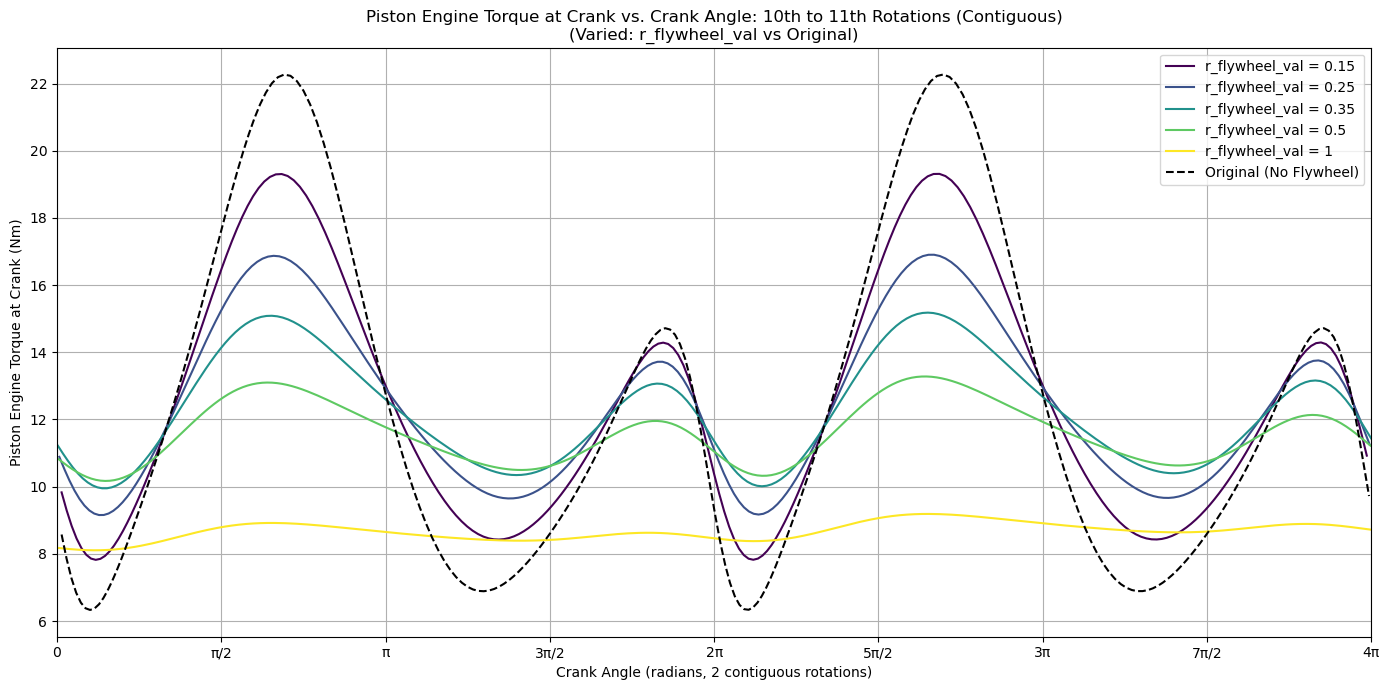

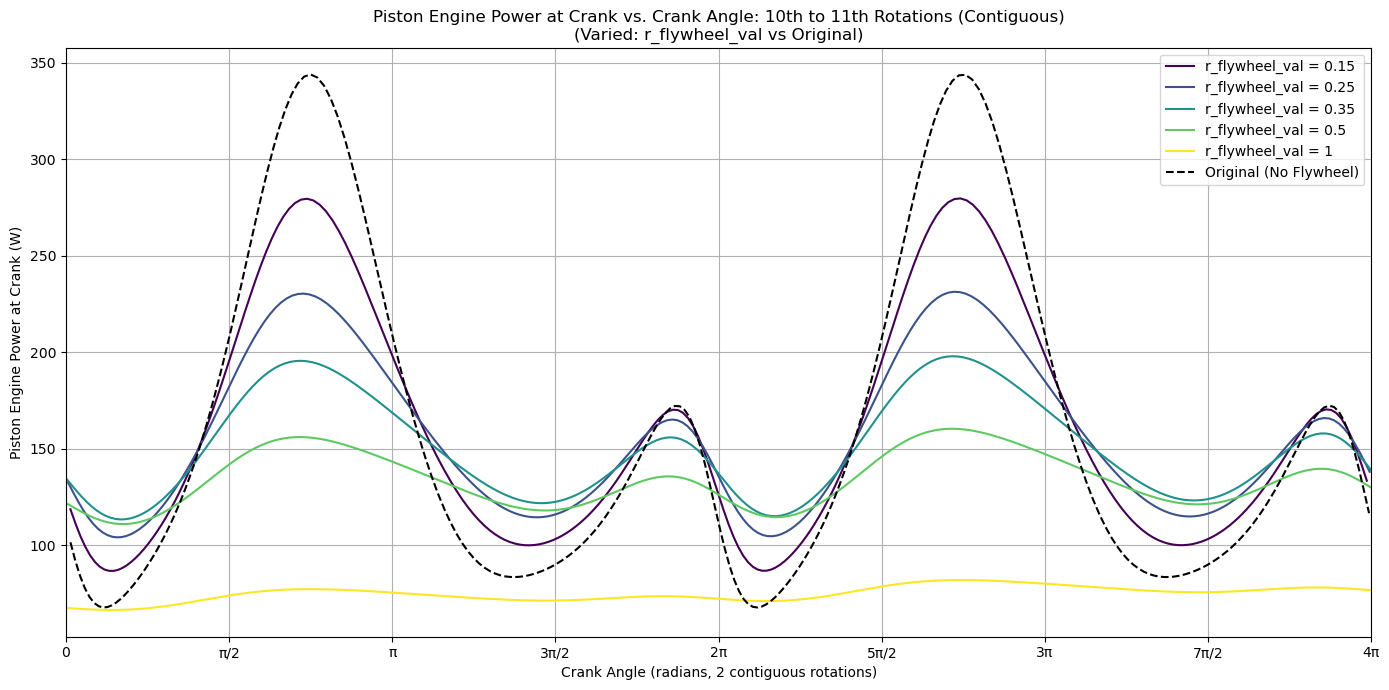

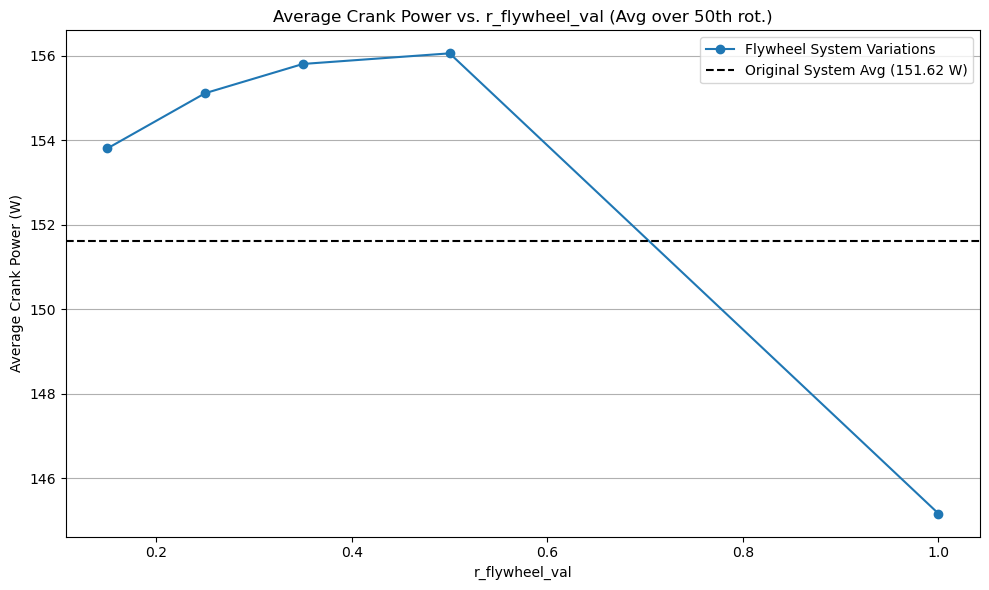


--- Calculating Average Power per Rotation (up to 80) ---
  Processing: r_flywheel_val=0.15
  Processing: r_flywheel_val=0.25
  Processing: r_flywheel_val=0.35
  Processing: r_flywheel_val=0.5
  Processing: r_flywheel_val=1
  Processing: Original (No Flywheel)


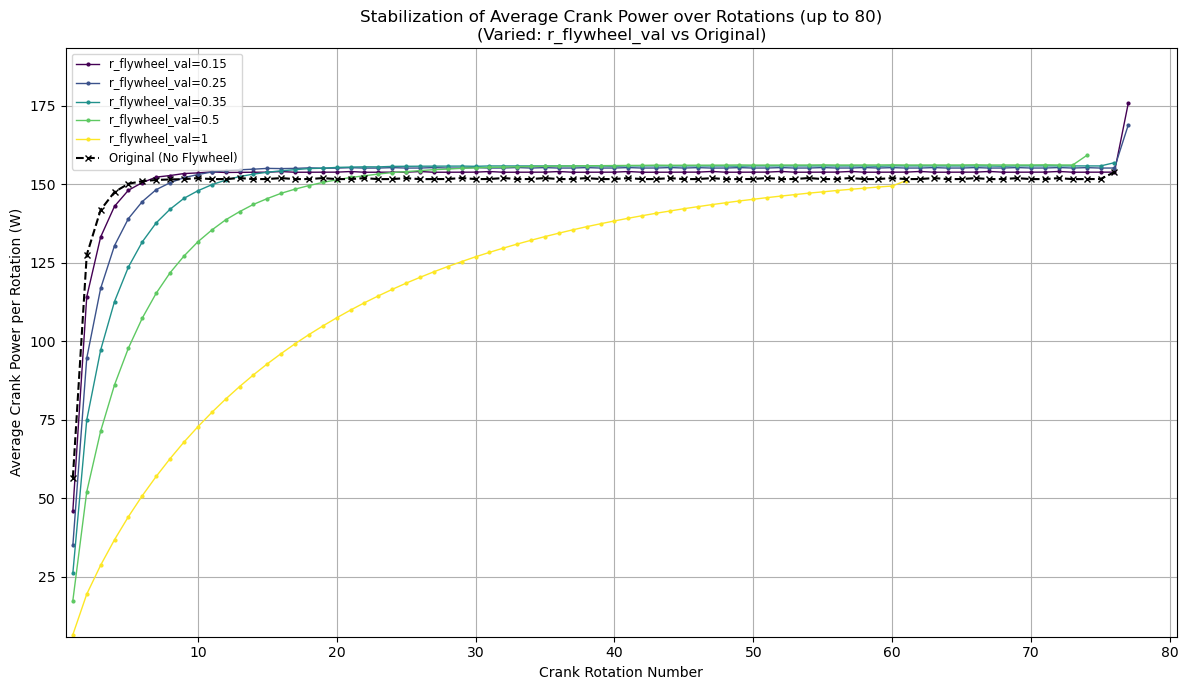

In [105]:
# Cell 16: Execute plotting (Now includes Avg Power vs Rotation)

if all_simulation_results:
    # Find the varied parameter from the first successful flywheel result
    param_actually_varied = "Unknown"
    first_successful_flywheel_result = next((res for res in all_simulation_results if res.get("success") and res.get("system_type") == "flywheel"), None)
    if first_successful_flywheel_result:
         param_actually_varied = first_successful_flywheel_result['param_varied']

    rotations_to_plot_contiguously = [10, 11] # For steady-state instantaneous plots
    rotation_to_average_over = 50             # For the single average value plot
    max_rotation_for_stabilization_plot = 80  # For the new plot

    print(f"\n--- Generating Comparison Plots (Varied: {param_actually_varied}) ---")

    # Plot 1: Instantaneous Engine Torque at Crank vs. Crank Angle (Steady State)
    plot_kinematic_vs_crank_angle_contiguous(all_simulation_results, param_actually_varied,
                                             "T_engine_crank", "Engine Torque at Crank", "Nm",
                                             rotations_to_display=rotations_to_plot_contiguously)

    # Plot 2: Instantaneous Engine Power at Crank vs. Crank Angle (Steady State)
    plot_kinematic_vs_crank_angle_contiguous(all_simulation_results, param_actually_varied,
                                             "P_engine_crank", "Engine Power at Crank", "W",
                                             rotations_to_display=rotations_to_plot_contiguously)

    # Plot 3: Average Crank Power (at specific rotation) vs. Varied Parameter
    plot_average_metric_vs_parameter(all_simulation_results, param_actually_varied,
                                     "P_engine_crank", "Average Crank Power", "W",
                                     rotation_for_avg=rotation_to_average_over)

    # --- NEW PLOT ---
    # Plot 4: Average Crank Power Stabilization vs. Rotation Number
    plot_avg_power_vs_rotation(all_simulation_results, param_actually_varied,
                               max_rotation=max_rotation_for_stabilization_plot)
    # --- END NEW PLOT ---


    # Optional: Plot Average Crank Torque vs. Varied Parameter
    # plot_average_metric_vs_parameter(all_simulation_results, param_actually_varied,
    #                                  "T_engine_crank", "Average Crank Torque", "Nm",
    #                                  rotation_for_avg=rotation_to_average_over)

    # Optional: Plot Piston Position Comparison
    # plot_kinematic_vs_crank_angle_contiguous(all_simulation_results, param_actually_varied,
    #                                          "y_piston", "Piston Position", "m",
    #                                          rotations_to_display=rotations_to_plot_contiguously)

else:
    print("No simulation results (flywheel or original) to plot. Please run Cell 14 and 14.5 first.")